# Feature to response correlation analysis on TF affinity scores obtained from a window of size 500bp around TSS
We decided to change the window size centered on the TSS of the genes estimating the binding affinities of the TFs binding in that region.

## Load the partitioned and normalized data (to save I/O operations)

In [1]:
## The code illustrating how the RData loaded in the cell below is generated (too heavy for jupyter to run).

## Read the static features and assign the ENSG column as rownames
# x <- read.table("/MMCI/MS/EpiregDeep2/work/Tools/TEPIC_GS/hg38_Static/500bp/STATIC_Features_hg38_500bp_Gene_View.txt", header= T, stringsAsFactors= F)
# rownames(x) <- x$ENSG
# x <- x[, -1]
#########################################################
## Read bulk rna data
# bulk.rna <- read.table("/MMCI/MS/DEEP-liver/work/Data/41/mRNA/LiHe/GRCh37/41_Hf01_LiHe_Ct_mRNA_K_1.LXPv1.20150530_genes.fpkm_tracking",header= T, stringsAsFactors =  F)
# new_gene_id <- sapply(seq(nrow(bulk.rna)), function(i)strsplit(bulk.rna$gene_id[i ], "\\.")[[1]][1])                                                                                                                                       
# bulk.rna$gene_id <- new_gene_id                                                                                                                                                                                                            
# bulk.rna.original <- bulk.rna                                                                                                                                                                                                              
# dupl.genes <- duplicated(bulk.rna$gene_id)                                                                                                                                                                                                 
# bulk.rna <- bulk.rna[!dupl.genes, ]                                                                                                                                                                                                        
# gene_names <- bulk.rna$gene_id                                                                                                                                                                                                             
# bulk.rna <- data.frame(FPKM= bulk.rna$FPKM)                                                                                                                                                                                                
# rownames(bulk.rna) <- gene_names               
#########################################################
## Find the genes in x (static features) that exist in bulk.rna
# x.hits <- which(rownames(x) %in% rownames(bulk.rna))
############
## subset x according to the hits with bulk.rna genes
# x <- x[x.hits, ]
#########################################################
## Find the bulk.rna genes corresponding to the static feature genes (for each gene in x look for the hit index in bulk.rna)
# idx <- NULL;
# for(i in seq(nrow(x)))
#    idx <- c(idx, which(rownames(x)[i] == rownames(bulk.rna)))
############
## subset y according to the hits with x genes
# y <- bulk.rna[idx, ] 
############
## Check if the subset variables match
# all.equal(rownames(x), rownames(bulk.rna)[idx])
##[1] TRUE
############
## Save the variables, ready to be loaded in jupyter
# save(x, y, file= "TF_hg38_500bp_LiHe.RData")

In [20]:
rm(list= ls())
load("../TF_hg38_500bp_LiHe.RData")

### List of variables in the workspace after loading the data file

In [21]:
print(ls())

[1] "x" "y"


### Dimensions of the training and test data

In [22]:
print("x:")
print(dim(x))

print("y:")
print(length(y))

[1] "x:"
[1] 52527   726
[1] "y:"
[1] 52527


In [23]:
print(range(x))
print(range(y))

[1] 0.000000 2.149298
[1]     0.0 12081.8


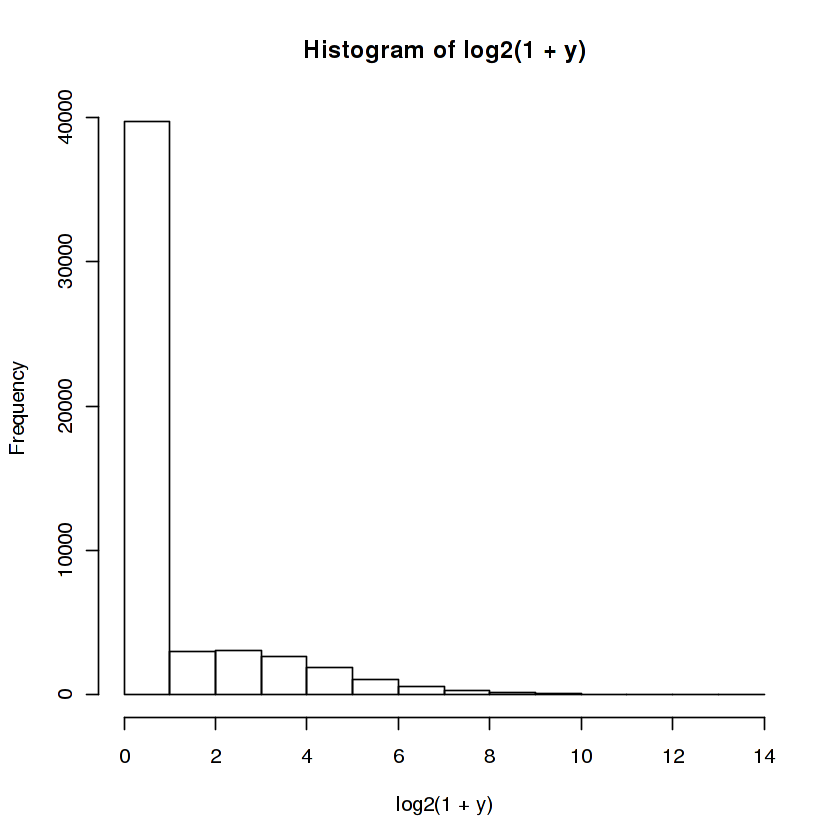

In [24]:
hist(log2(1 + y))

## Compute feature to response correlations (unfiltered data)

### Raw data (original space)

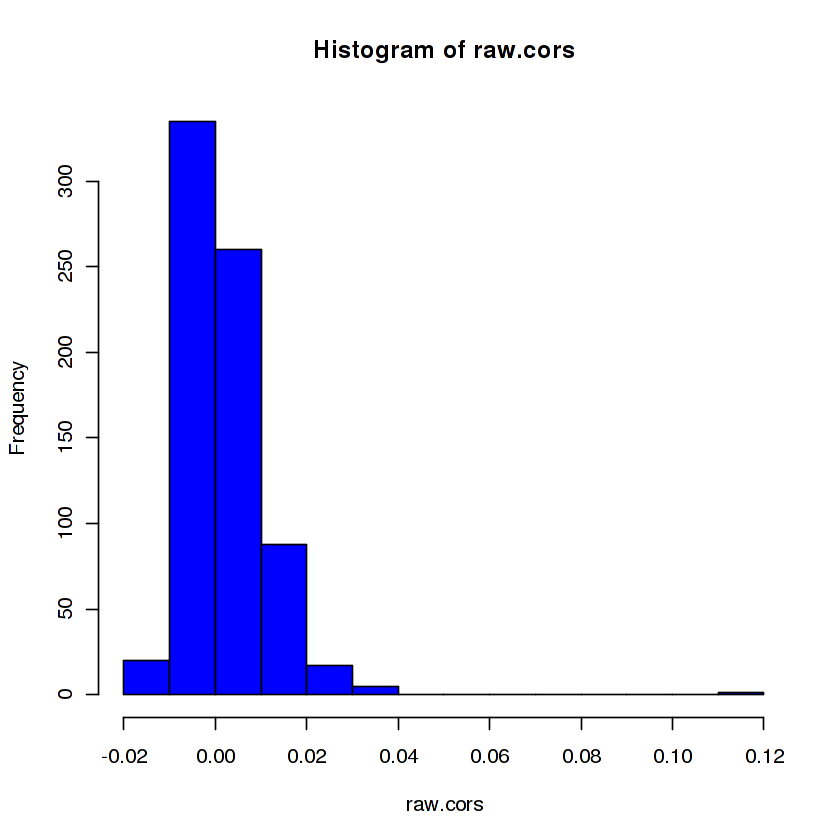

In [25]:
raw.cors <- sapply(seq(ncol(x)), function(i)cor(y, x[, i]))
hist(raw.cors, col= "blue")

### Log-transformed data (log space)

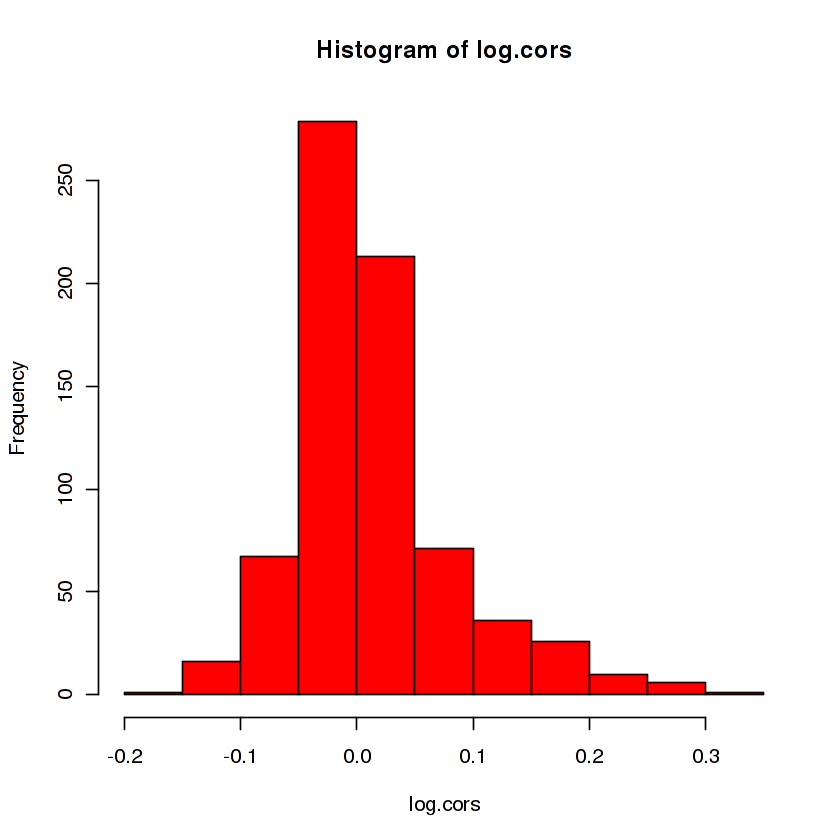

In [26]:
log.cors <- sapply(seq(ncol(x)), function(i)cor(log2(1 + y), log2(1 + x[, i])))
hist(log.cors, col= "red")

**Apparently log transforming the data reduces the association between features and response**

## Remove zero-expressed genes

In [27]:
zeros.idx <- which(y == 0)
print(length(zeros.idx))

[1] 29948


In [28]:
x_filtered <- x[-zeros.idx, ]
y_filtered <- y[-zeros.idx]

In [29]:
print(dim(x_filtered))
print(length(y_filtered))

[1] 22579   726
[1] 22579


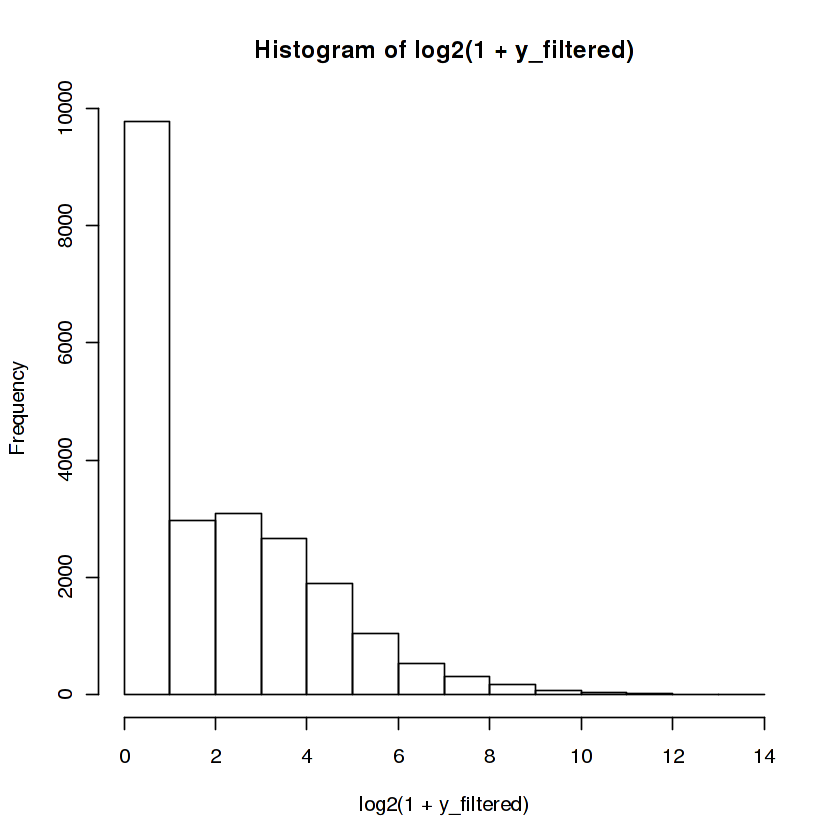

In [30]:
hist(log2(1 + y_filtered))

## Compute feature to response correlations (filtered data)

### Raw filtered data (original space)

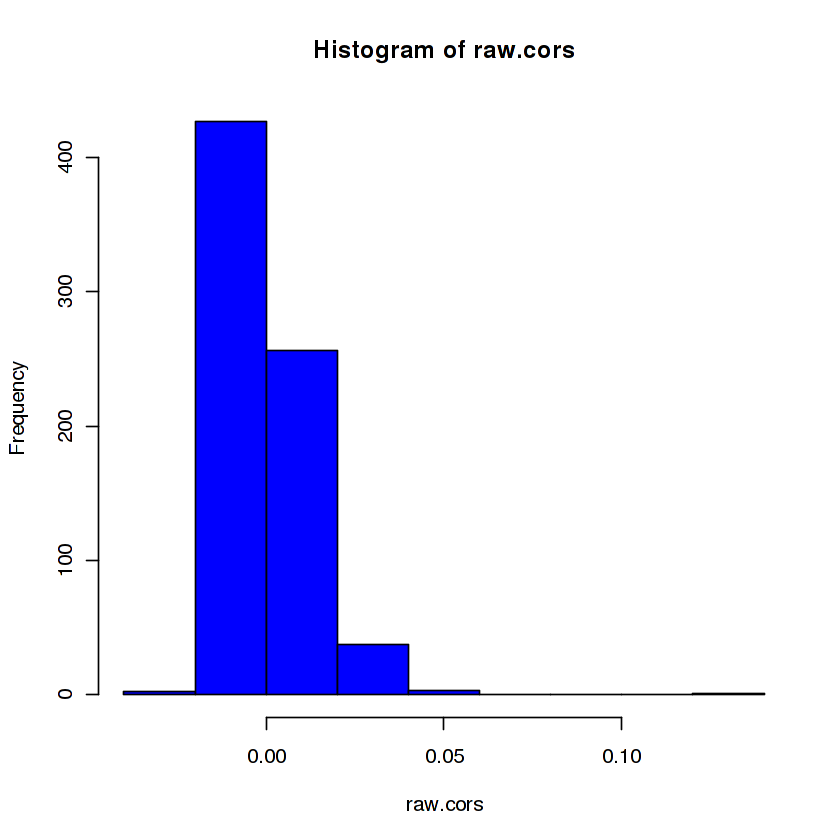

In [31]:
raw.cors <- sapply(seq(ncol(x_filtered)), function(i)cor(y_filtered, x_filtered[, i]))

hist(raw.cors, col= "blue")

### Log-transformed filtered data (log space)

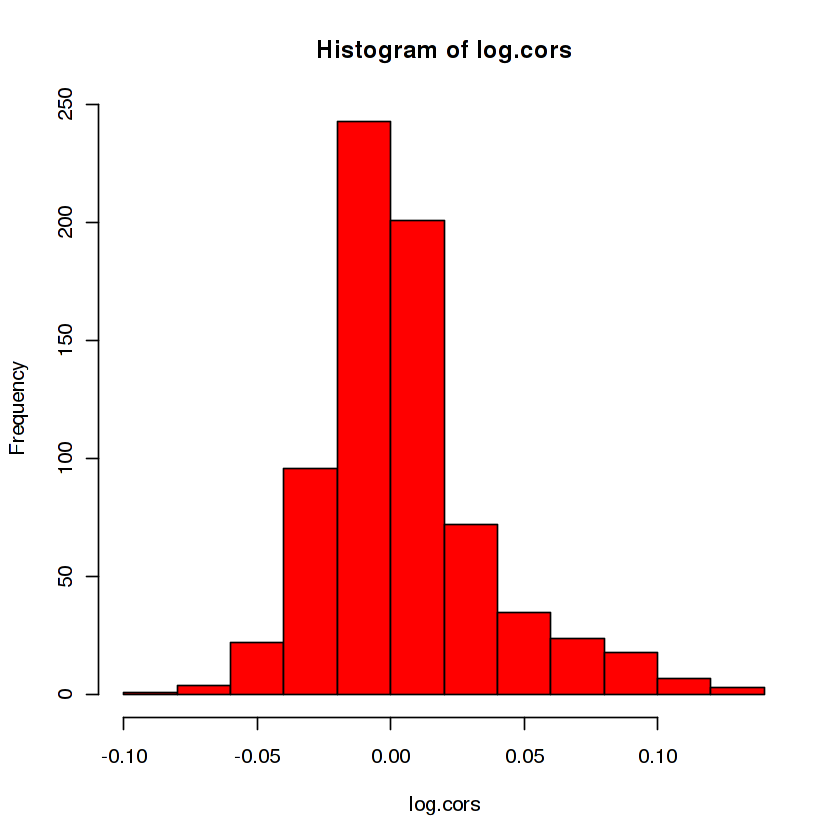

In [32]:
log.cors <- sapply(seq(ncol(x_filtered)), function(i)cor(log2(1 + y_filtered), log2(1 + x_filtered[, i])))

hist(log.cors, col= "red")

# Conclusion
* We examined the influence of the window size ([100bp](https://github.com/fba67/scMTL/blob/master/feat2resp_bulk_LiHe_100bpWinTF.ipynb), [200bp](https://github.com/fba67/scMTL/blob/master/feat2resp_bulk_LiHe_200bpWinTF.ipynb), and [2kb](https://github.com/fba67/scMTL/blob/master/feat2resp_bulk_LiHe_2kbWinTF.ipynb)) used to annotate the TF binding affinities around the TSS on the feature values and how that affects the strength of linear association between features and response
* Also, measured the correlation between each TF and gene expression for both 1) raw and 2) log-transformed data.
* We filtered the zero-expressed genes (discarded ~30,000 genes with exact zero expression).

# Train Elastic Net models on the filtered data

## Partition data into training and test sets
80% for training and 20% for test

In [36]:
train_cnt <- floor(nrow(x) * .8)
print(train_cnt)

[1] 42021


In [37]:
set.seed(1)
shuffle.idx <- sample(nrow(x))

In [38]:
train_x <- x[shuffle.idx[seq(train_cnt)], ]
train_y <- y[shuffle.idx[seq(train_cnt)]]

test_x <- x[-shuffle.idx[seq(train_cnt)], ]
test_y <- y[-shuffle.idx[seq(train_cnt)]]

print(dim(train_x))
print(dim(test_x))

[1] 42021   726
[1] 10506   726


In [39]:
train_x <- log2(1 + train_x)
train_y <- log2(1 + train_y)

test_x <- log2(1 + test_x)
test_y <- log2(1 + test_y)

### Normalize data

In [40]:
mean.train <- apply(x, 2, FUN= mean)
sd.train <- apply(x, 2, FUN= sd)
train_x <- scale(train_x)

test_x <- scale(test_x, center = mean.train, scale = sd.train)

In [41]:
train_y <- scale(train_y)

col_means_train <- attr(train_y, "scaled:center") 
col_stddevs_train <- attr(train_y, "scaled:scale")
test_y <- scale(test_y, center = col_means_train, scale = col_stddevs_train)

In [42]:
library(glmnet)
library(doMC)
registerDoMC(cores=4)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Loading required package: iterators
Loading required package: parallel


## CV round on the denoted alpha search grid

In [43]:
alphas <- seq(0, 1, .05)
el.res <- list()
for(i in seq(length(alphas)))
    el.res[[i]] <- cv.glmnet(x= as.matrix(train_x), y= as.numeric(train_y), alpha= alphas[i], nfolds= 5, parallel= T, standardize =F)

## Fetch the best alpha value

In [44]:
all.cvms <- sapply(seq(length(el.res)), function(i) min(el.res[[i]]$cvm))
best.el.cv <- el.res[[which.min(all.cvms)]]
best_alpha_idx <- which.min(all.cvms)

## Train the final elastic net model with the selected optimal hyper-parameters obtained from the CV round

In [45]:
final_el <- glmnet(x= as.matrix(train_x), y= as.numeric(train_y), lambda= el.res[[best_alpha_idx]]$lambda.min,
                   alpha= alphas[best_alpha_idx])

### Compute predictions on training data

In [46]:
pred.res.train <- predict(final_el, as.matrix(train_x),s= el.res[[best_alpha_idx]]$lambda.min, alpha= alphas[best_alpha_idx])
cor(pred.res.train, train_y)

0.4524226


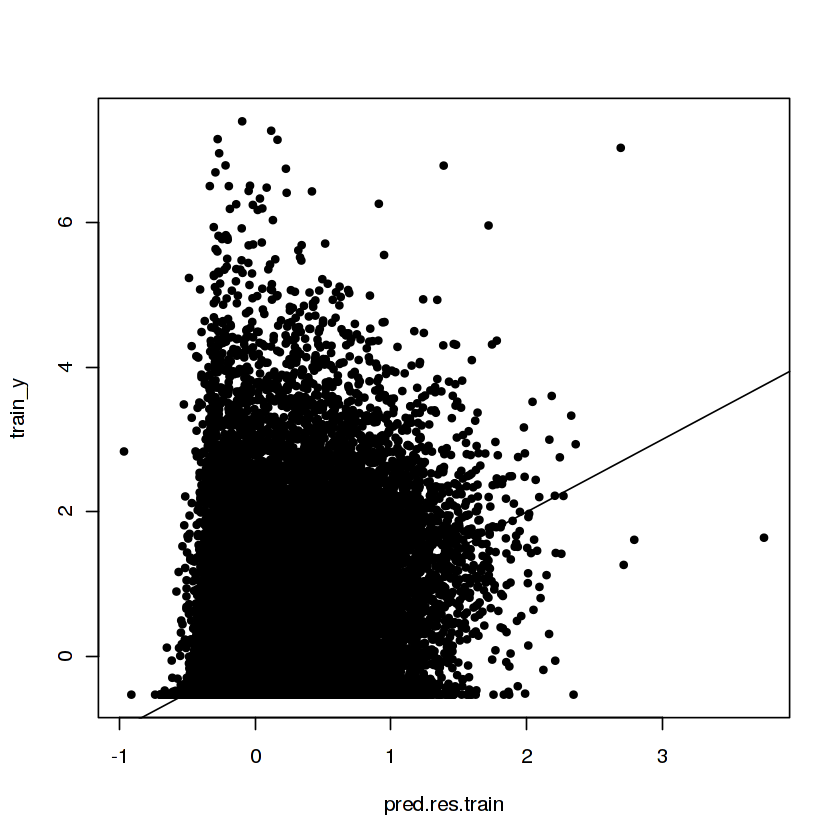

In [61]:
plot(pred.res.train, train_y, pch= 20)
abline(a=0, b= 1)

### Compute predictions on test data

In [47]:
pred.res.test <- predict(final_el, as.matrix(test_x),s= el.res[[best_alpha_idx]]$lambda.min, alpha= alphas[best_alpha_idx])
cor(pred.res.test, test_y)

0.434774


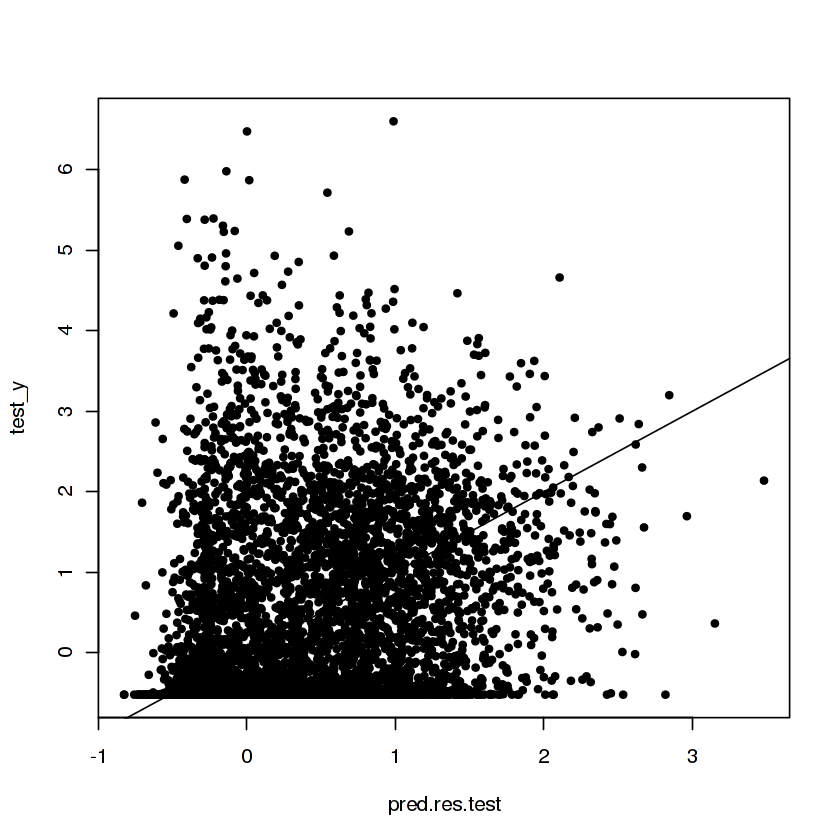

In [60]:
plot(pred.res.test, test_y, pch= 20)
abline(a=0, b= 1)

## Model coefficients representing the top TFs

[1]  0.0000000000  0.0006624392  0.0000000000  0.0000000000 -0.0024707018
[6] -0.0267548191

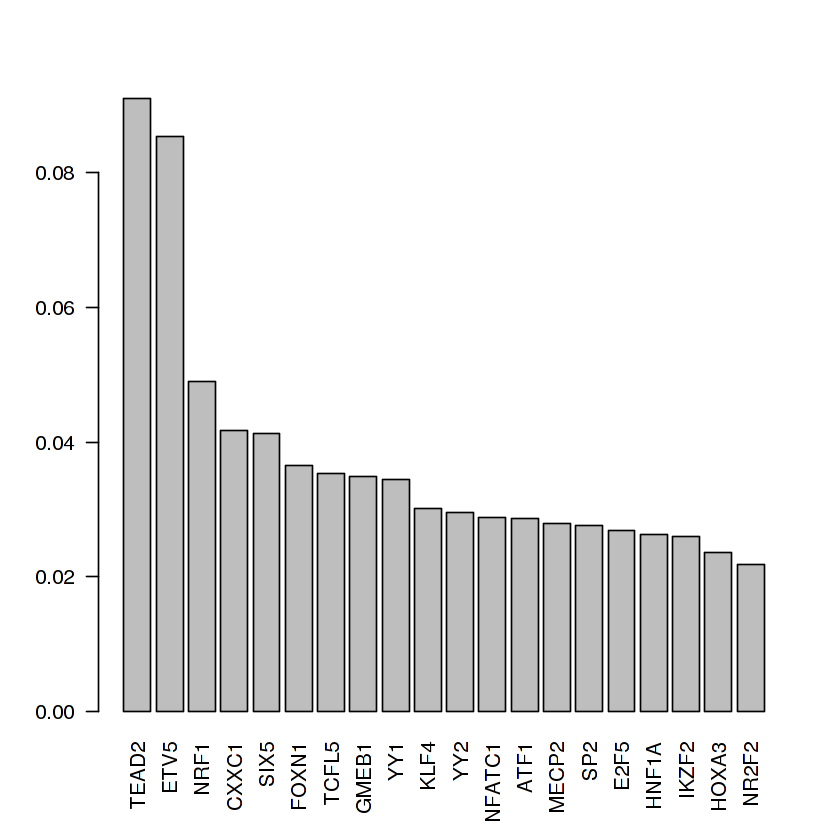

In [72]:
tf.names <- rownames(final_el$beta)
top.tfs <- order(as.numeric(final_el$beta), decreasing = T)[seq(20)]
barplot(as.numeric(final_el$beta)[top.tfs], las= 2, names.arg= tf.names[top.tfs])

# Repeat correlation analysis on the protein conding genes

In [48]:
library(biomaRt)

In [49]:
ensembl = useEnsembl(biomart="ensembl")
martDB <- useDataset(ensembl, dataset="hsapiens_gene_ensembl")

In [50]:
pc <- getBM(attributes=c("ensembl_gene_id","external_gene_name","description"), filters='biotype',
      values=c('protein_coding'), mart= martDB)

In [51]:
dim(pc)
head(pc)

[1] 22686     3

ensembl_gene_id,external_gene_name,description
ENSG00000275568,ARHGAP11A,Rho GTPase activating protein 11A [Source:HGNC Symbol;Acc:HGNC:15783]
ENSG00000275049,AC011295.1,
ENSG00000276804,NLRP7,NLR family pyrin domain containing 7 [Source:HGNC Symbol;Acc:HGNC:22947]
ENSG00000276565,AP006285.3,
ENSG00000281024,SURF2,surfeit 2 [Source:HGNC Symbol;Acc:HGNC:11475]
ENSG00000278695,GSTT2B,glutathione S-transferase theta 2B (gene/pseudogene) [Source:HGNC Symbol;Acc:HGNC:33437]


In [52]:
pc.hits <- which(rownames(x) %in% pc$ensembl_gene_id)

In [59]:
length(pc.hits)
head(rownames(x))
head(rownames(y))

[1] 19221

[1] "ENSG00000110514" "ENSG00000086015" "ENSG00000211769" "ENSG00000211768"
[5] "ENSG00000250337" "ENSG00000211767"

NULL

In [54]:
pc.x <- x[pc.hits, ]
pc.y <- y[pc.hits]

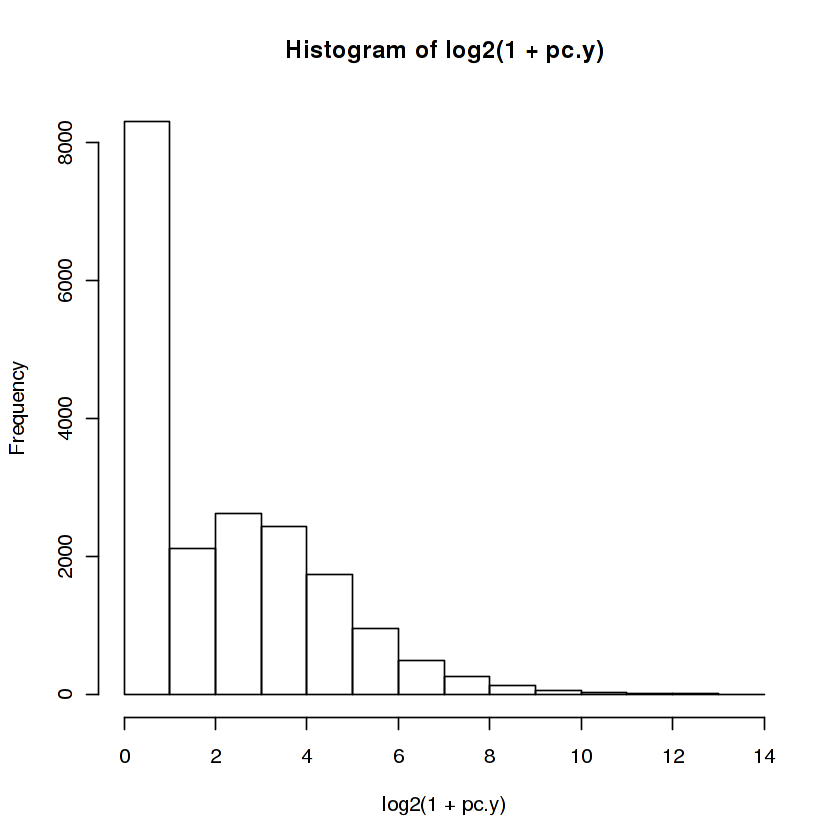

In [55]:
hist(log2(1 + pc.y))

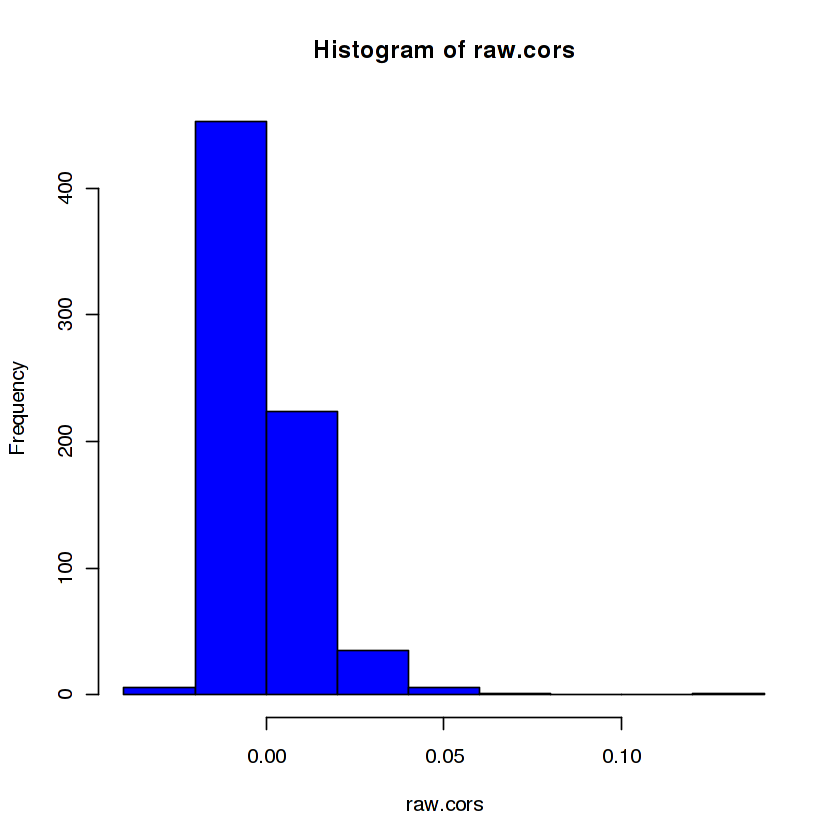

In [56]:
raw.cors <- sapply(seq(ncol(pc.x)), function(i)cor(pc.y, pc.x[, i]))

hist(raw.cors, col= "blue")

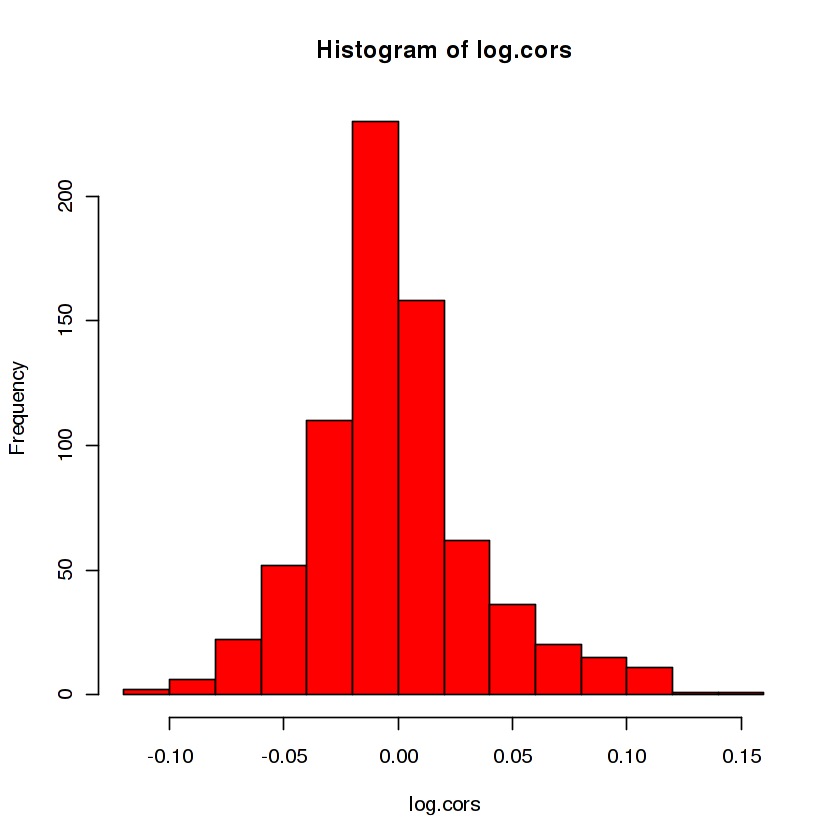

In [57]:
log.cors <- sapply(seq(ncol(pc.x)), function(i)cor(log2(1 + pc.y), log2(1 + pc.x[, i])))

hist(log.cors, col= "red")

# Conclusion
* Restricting the set of genes to protein coding genes doesn't seem to enhance the correlation between features and response. Another indication for the contriibution of the lowly (zero) expressed genes to the correlation values.